# Extract day night and sleep data

In [1]:
# Import modules

import os
import pandas as pd
import numpy as np
import scipy.stats as sp
import datetime
import seaborn as sns
from datetime import date, timedelta
from matplotlib import pyplot as plt
from scipy.stats import skew

sns.set_style(style='whitegrid')
sns.set_palette(palette='colorblind')

In [2]:
# Petter's code for extracting all the data files and then combining them.

def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

In [3]:
# Extration of all the acitvity data into one data frame

df = extract_folder('../data/depresjon')
df.shape


(1571706, 5)

In [4]:
# Read scores.csv in as a dataframe

scores = pd.read_csv('data/depresjon/scores.csv')

# Rename the number column to "id" matching the data frames title
scores.rename(columns={'number':'id'}, inplace=True)

df = pd.merge(df, scores, on='id')
# remove unused columns

df.drop(['days','age','afftype','melanch','inpatient','edu','marriage','work','madrs1','madrs2'], axis=1, inplace=True)


In [5]:
df

,timestamp,date,activity,id,label,gender
0,2003-03-18 15:00:00,2003-03-18,60,control_1,0,2
1,2003-03-18 15:01:00,2003-03-18,0,control_1,0,2
2,2003-03-18 15:02:00,2003-03-18,264,control_1,0,2
3,2003-03-18 15:03:00,2003-03-18,662,control_1,0,2
4,2003-03-18 15:04:00,2003-03-18,293,control_1,0,2
...,...,...,...,...,...,...
1571701,2004-06-10 15:03:00,2004-06-10,0,condition_9,1,2
1571702,2004-06-10 15:04:00,2004-06-10,0,condition_9,1,2
1571703,2004-06-10 15:05:00,2004-06-10,449,condition_9,1,2
1571704,2004-06-10 15:06:00,2004-06-10,0,condition_9,1,2


In [6]:
# Function to clasify each row of data as either day (0) or night (1) 

def day_or_night (dataframe,day_start,day_end):
    
    # day night classifying function
    def day_night_test(time):
        if day_start <= time.hour < day_end:
            return (0)
        else:
            return (1)
    
    # Create a copy of the data frame
    dayNight_df = dataframe.copy()
    
    # Add in the new column with day or night values
    dayNight_df['day_night'] = dayNight_df['timestamp'].apply(day_night_test)
    return (dayNight_df)

# Day values using rodriguez model values of 8:00 - 20:00. 

DN_df = day_or_night(df,8,20)

In [7]:
# Function to create a field of acitve (1) and non-active (0) time

def active_nonactive (dataframe):
    
    # function to test if a minute is active ('1') or inactive('0')
    def time_test(activity):
        if activity < 5:
            return ('0')
        else:
            return ('1') 
    
    # Create a copy of the data frame    
    new_df = dataframe.copy()
    
    # Create a new column classifying each minute as acitve or inactive
    new_df['col1'] = new_df['activity'].apply(time_test)
    
    # Create a new column that sums the 11 values (5 below and 5 above) the trigger value 
    new_df['col2'] = new_df['col1'].rolling(window=11, center=True).sum()
    
    # Function to test if a period is active or inactive
    def activ_test(value):
        if value >= 2:
            return (1)    
        elif value < 2:
            return (0)
        else:
            return ('NaN')
        
    # Create the column of active or inactive periods   
    new_df['active_inactive'] = new_df['col2'].apply(activ_test)
    
    # Drop the unnecessary columns created
    new_df.drop(['col1','col2'], axis=1, inplace=True)
    
    return(new_df)

active_df = active_nonactive(DN_df)


In [8]:
active_df.head(100)

,timestamp,date,activity,id,label,gender,day_night,active_inactive
0,2003-03-18 15:00:00,2003-03-18,60,control_1,0,2,0,NaN
1,2003-03-18 15:01:00,2003-03-18,0,control_1,0,2,0,NaN
2,2003-03-18 15:02:00,2003-03-18,264,control_1,0,2,0,NaN
3,2003-03-18 15:03:00,2003-03-18,662,control_1,0,2,0,NaN
4,2003-03-18 15:04:00,2003-03-18,293,control_1,0,2,0,NaN
...,...,...,...,...,...,...,...,...
95,2003-03-18 16:35:00,2003-03-18,194,control_1,0,2,0,1
96,2003-03-18 16:36:00,2003-03-18,208,control_1,0,2,0,1
97,2003-03-18 16:37:00,2003-03-18,146,control_1,0,2,0,1
98,2003-03-18 16:38:00,2003-03-18,30,control_1,0,2,0,1


In [9]:
# Function to crop to only full days of data

def fullDays(dataframe):
    
    # Create a list of participants
    participants = dataframe['id'].unique()
    
    # Create an empty dataframe to be populated
    df_new = pd.DataFrame({})
    
    # Create a subset of the df for each participant and find the initial timestamp and date
    for participant in participants:
        df_tochange = dataframe[dataframe['id'] == participant]
        
        min_timestamp = df_tochange['timestamp'].min()    # first timestamp entry 
        min_date = df_tochange['date'].min()       # first date entry 
        
        # Remove all values before 00:00 on the first full day  
        if min_date < min_timestamp:
            min_fullday_date = min_date + timedelta(1)
            df_minchange = df_tochange[df_tochange['date'] >= min_fullday_date]
        
        else:
            df_minchange = df_tochange.copy()
  
        max_timestamp = df_minchange['timestamp'].max()    # last timestamp entry 
        max_date = df_minchange['date'].max()     # last date entry 
        
        # Remove all values after 23:59 on the last full day
        if max_date < max_timestamp:
            df_maxchange = df_minchange[df_minchange['date'] < max_date]
        else:
            df_maxchange = df_minchange.copy()
        
        # Combine all subsets back into one dataframe 
        df_new = pd.concat([df_new,df_maxchange])
        
    return (df_new)

fulldays_df = fullDays(active_df)

In [10]:
# Function to match the number of dates stated in the scores.csv with the activity data
def trueDates (dataframe):
    
    # Create a new empty dataframe
    df_new = pd.DataFrame({})
    
    # Create a list of participants
    participants = dataframe['id'].unique()
    
    # Create a subset of the df for each participant
    for participant in participants:
        df_tochange = dataframe[dataframe['id'] == participant]
        
        # Identify the expected number of days for each participant
        trueDays = scores.loc[scores['id'] == participant, 'days'].values[0]
        
        # Identify the first date for each participant
        min_date = dataframe.loc[dataframe['id'] == participant, 'date'].min()
        
        # Indentify the expected last date for each participant
        min_truedate = min_date + timedelta(int(trueDays))
        
        # Remove all data outside the expected range
        df_reduce = df_tochange[df_tochange['date'] < min_truedate]
        
        # Combine all subsets back into one dataframe 
        df_new = pd.concat([df_new,df_reduce])
    
    return (df_new)

trueDates_df = trueDates(fulldays_df)

In [11]:
trueDates_df

,timestamp,date,activity,id,label,gender,day_night,active_inactive
540,2003-03-19 00:00:00,2003-03-19,0,control_1,0,2,1,0
541,2003-03-19 00:01:00,2003-03-19,0,control_1,0,2,1,0
542,2003-03-19 00:02:00,2003-03-19,0,control_1,0,2,1,0
543,2003-03-19 00:03:00,2003-03-19,0,control_1,0,2,1,1
544,2003-03-19 00:04:00,2003-03-19,175,control_1,0,2,1,1
...,...,...,...,...,...,...,...,...
1570793,2004-06-09 23:55:00,2004-06-09,169,condition_9,1,2,1,1
1570794,2004-06-09 23:56:00,2004-06-09,169,condition_9,1,2,1,1
1570795,2004-06-09 23:57:00,2004-06-09,169,condition_9,1,2,1,1
1570796,2004-06-09 23:58:00,2004-06-09,169,condition_9,1,2,1,1


In [12]:
print((trueDates_df['active_inactive'] == 'NaN').sum())

0


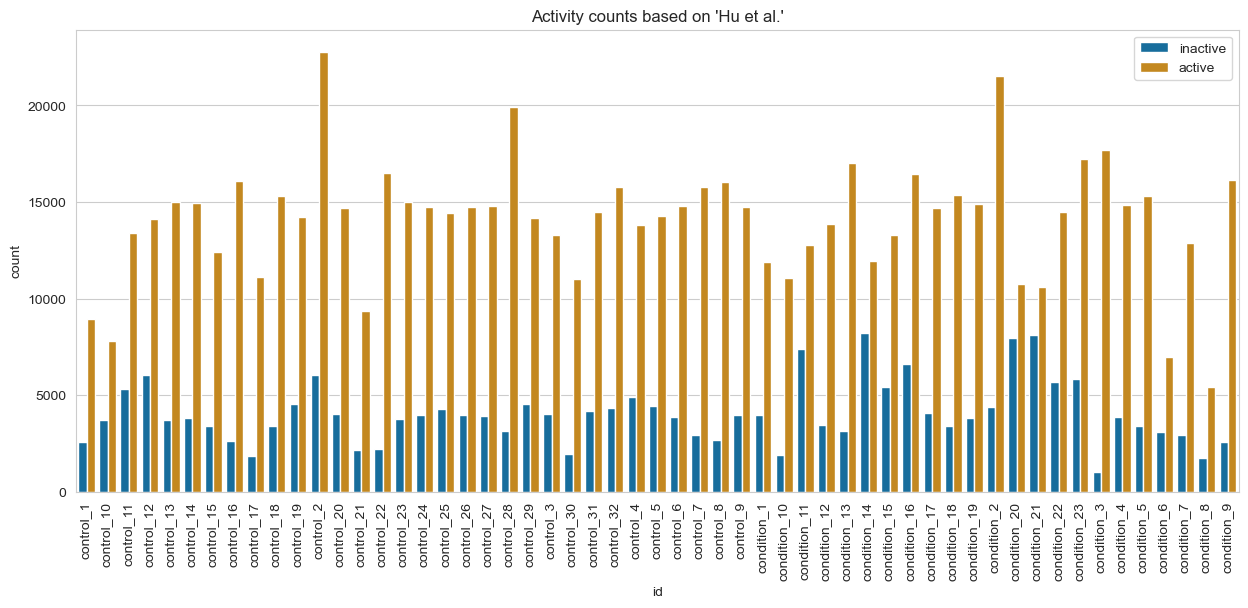

In [13]:
plt.figure(figsize=(15, 6))

sns.countplot(data=trueDates_df, x='id', hue='active_inactive')
plt.xticks(rotation=90)
plt.title("Activity counts based on 'Hu et al.'")
plt.legend(["inactive","active"])
plt.show()

In [14]:
trueDates_df.head()

,timestamp,date,activity,id,label,gender,day_night,active_inactive
540,2003-03-19 00:00:00,2003-03-19,0,control_1,0,2,1,0
541,2003-03-19 00:01:00,2003-03-19,0,control_1,0,2,1,0
542,2003-03-19 00:02:00,2003-03-19,0,control_1,0,2,1,0
543,2003-03-19 00:03:00,2003-03-19,0,control_1,0,2,1,1
544,2003-03-19 00:04:00,2003-03-19,175,control_1,0,2,1,1


In [15]:
# Read in sunlight data obtain from the website
# Sunrise and sunset by month for Oslo 
# 'https://www.worlddata.info/europe/norway/sunset.php'

sunlight = pd.read_csv('data/depresjon/Norway_Sunlight.csv')

# add month column for merging 
trueDates_df['month'] = pd.to_datetime(trueDates_df['timestamp']).dt.month

# merge dataframes
merged_df = trueDates_df.copy()
merged_df = pd.merge(merged_df, sunlight, on='month', how='inner')

# remove unnecessary columns       
merged_df.drop('month', axis=1, inplace=True)

In [16]:
merged_df

,timestamp,date,activity,id,label,gender,day_night,active_inactive,sunrise,sunset
0,2003-03-19 00:00:00,2003-03-19,0,control_1,0,2,1,0,06:29,18:21
1,2003-03-19 00:01:00,2003-03-19,0,control_1,0,2,1,0,06:29,18:21
2,2003-03-19 00:02:00,2003-03-19,0,control_1,0,2,1,0,06:29,18:21
3,2003-03-19 00:03:00,2003-03-19,0,control_1,0,2,1,1,06:29,18:21
4,2003-03-19 00:04:00,2003-03-19,175,control_1,0,2,1,1,06:29,18:21
...,...,...,...,...,...,...,...,...,...,...
997675,2004-06-09 23:55:00,2004-06-09,169,condition_9,1,2,1,1,03:50,22:44
997676,2004-06-09 23:56:00,2004-06-09,169,condition_9,1,2,1,1,03:50,22:44
997677,2004-06-09 23:57:00,2004-06-09,169,condition_9,1,2,1,1,03:50,22:44
997678,2004-06-09 23:58:00,2004-06-09,169,condition_9,1,2,1,1,03:50,22:44


In [17]:
# Function to clasify each row of data as either light (0) or dark (1) 

def light_dark(dataframe):
    
    # extract time, sunrise and sunset columns 
    # convert sunrise and sunset columns to time format        
    dataframe['time'] = pd.to_datetime(dataframe['timestamp']).dt.time
    sunrise = pd.to_datetime(dataframe['sunrise']).dt.time
    sunset = pd.to_datetime(dataframe['sunset']).dt.time
    time = dataframe['time']
        
    # create a list of when it is light(0) or dark(1)
    size = len(sunrise)
    light_dark = []
    for n in range (0,size):
        if sunrise[n] <= time[n] < sunset[n]:
            light_dark.append(0)
        else:
            light_dark.append(1)

    # add list as a new column 'light_dark' to dataframe    
    dataframe['light_dark'] = light_dark

    # remove unnecessary columns       
    dataframe.drop(['time','sunrise','sunset'], axis=1, inplace=True)
    
    return(dataframe)
    

LD_df = light_dark(merged_df)

C:\Users\44778\AppData\Local\Temp\ipykernel_22524\1526019979.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sunrise = pd.to_datetime(dataframe['sunrise']).dt.time
C:\Users\44778\AppData\Local\Temp\ipykernel_22524\1526019979.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sunset = pd.to_datetime(dataframe['sunset']).dt.time


In [18]:
LD_df.head()

,timestamp,date,activity,id,label,gender,day_night,active_inactive,light_dark
0,2003-03-19 00:00:00,2003-03-19,0,control_1,0,2,1,0,1
1,2003-03-19 00:01:00,2003-03-19,0,control_1,0,2,1,0,1
2,2003-03-19 00:02:00,2003-03-19,0,control_1,0,2,1,0,1
3,2003-03-19 00:03:00,2003-03-19,0,control_1,0,2,1,1,1
4,2003-03-19 00:04:00,2003-03-19,175,control_1,0,2,1,1,1


In [19]:
# Function to find percentage activity at night/day/light/dark

def activeAtNight (dataframe):
    
    # Create a new empty dataframe
    df_ndld = pd.DataFrame({})
    
    # Create a list of participants
    participants = dataframe['id'].unique()
    
    
    # List for storing values
    
    activeNightList = []
    inactiveDayList = []
    activeDarkList = []
    inactiveLightList = []
    labelList = []
    
    # Create a subset of the df for each participant
    for participant in participants:
        
        if "control" in participant.lower():
            labelList.append(0)
        else:
            labelList.append(1)
        
        df_tochange = dataframe[dataframe['id'] == participant]
        
        inactive_day = len(df_tochange[(df_tochange['day_night'] == 0) & (df_tochange['active_inactive'] == 0)])
        active_night = len(df_tochange[(df_tochange['day_night'] == 1) & (df_tochange['active_inactive'] == 1)])
        night = len(df_tochange[(df_tochange['day_night'] == 1)])
        day = len(df_tochange[(df_tochange['day_night'] == 0)])
        
        inactive_light = len(df_tochange[(df_tochange['light_dark'] == 0) & (df_tochange['active_inactive'] == 0)])
        active_dark = len(df_tochange[(df_tochange['light_dark'] == 1) & (df_tochange['active_inactive'] == 1)])
        dark = len(df_tochange[(df_tochange['light_dark'] == 1)])
        light = len(df_tochange[(df_tochange['light_dark'] == 0)])        
        
        
        activeNightList.append(active_night/night)
        inactiveDayList.append(inactive_day/day)
        activeDarkList.append(active_dark/dark)
        inactiveLightList.append(inactive_light/light)
    
    df_ndld['id'] = participants
    df_ndld['activeNight'] = activeNightList
    df_ndld['inactiveDay'] = inactiveDayList
    df_ndld['activeDark'] = activeDarkList
    df_ndld['inactiveLight'] = inactiveLightList
    df_ndld['label'] = labelList

    return(df_ndld)

AN = activeAtNight(LD_df)
    


In [20]:
AN_new = pd.merge(AN, scores, on='id')

# remove unused columns

AN_new.drop(['days','age','afftype','melanch','inpatient','edu','marriage','work','madrs1','madrs2'], axis=1, inplace=True)

In [21]:
AN_new.head()

,id,activeNight,inactiveDay,activeDark,inactiveLight,label,gender
0,control_1,0.621181,0.068229,0.693510,0.138694,0,2
1,control_22,0.786859,0.022543,0.824022,0.028351,0,1
2,control_23,0.667521,0.067308,0.720039,0.076641,0,1
3,control_24,0.645833,0.070726,0.709045,0.117460,0,2
4,control_25,0.559829,0.018803,0.617816,0.044741,0,1


In [22]:
ANM = AN_new[AN_new['gender'] == 2]
ANF = AN_new[AN_new['gender'] == 1]

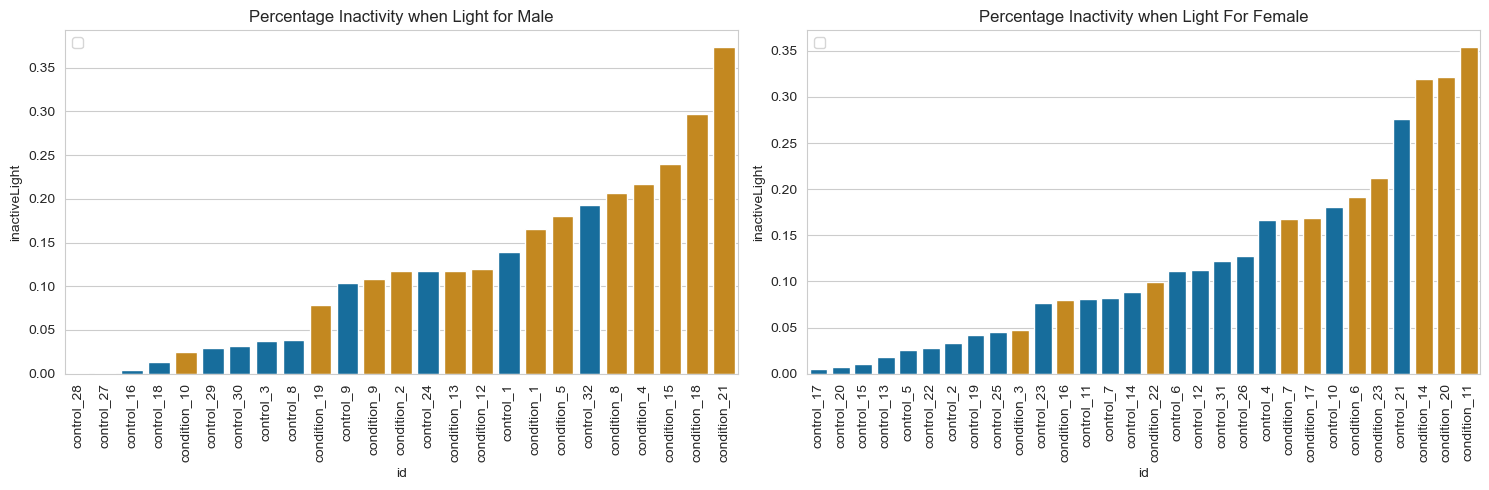

In [23]:
# Sort dataframes by 'activeNight' column
scaled_features_sortedM = ANM.sort_values(by='inactiveLight')
scaled_features_sortedN = ANF.sort_values(by='inactiveLight')

# Create a figure and two subplots, arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot data on the first subplot
sns.barplot(data=scaled_features_sortedM, x='id', y='inactiveLight', hue='label', dodge=False, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Percentage Inactivity when Light for Male")
axs[0].legend([])

# Plot data on the second subplot
sns.barplot(data=scaled_features_sortedN, x='id', y='inactiveLight', hue='label', dodge=False, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Percentage Inactivity when Light For Female")
axs[1].legend([])

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plots
plt.show()

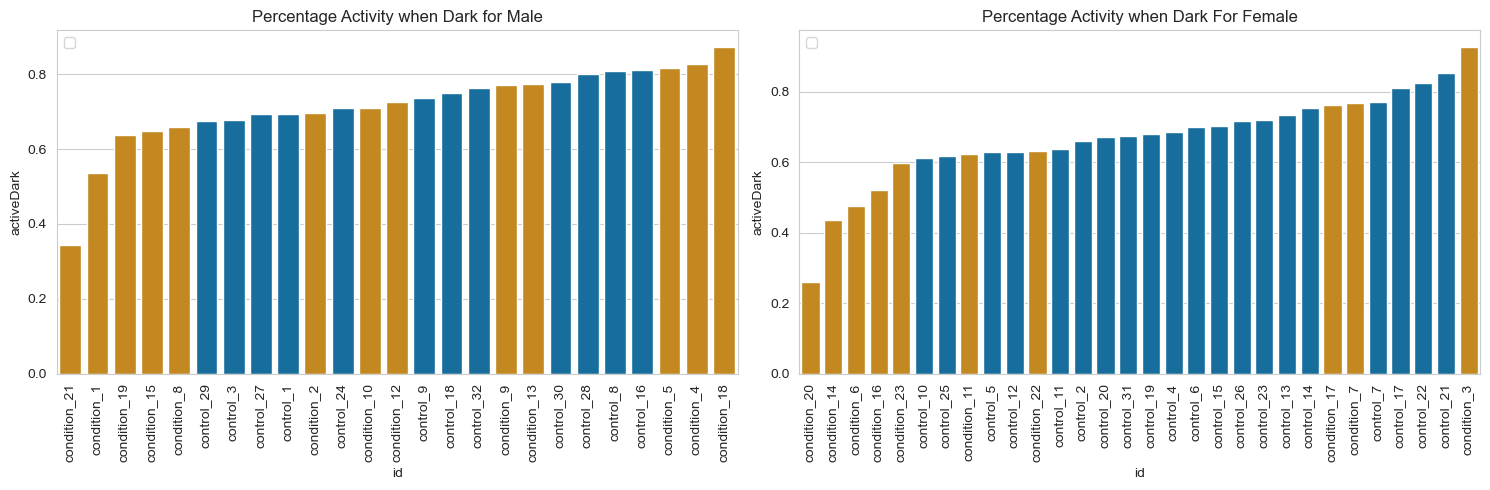

In [24]:
# Sort dataframes by 'activeNight' column
scaled_features_sortedM = ANM.sort_values(by='activeDark')
scaled_features_sortedN = ANF.sort_values(by='activeDark')

# Create a figure and two subplots, arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot data on the first subplot
sns.barplot(data=scaled_features_sortedM, x='id', y='activeDark', hue='label', dodge=False, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Percentage Activity when Dark for Male")
axs[0].legend([])

# Plot data on the second subplot
sns.barplot(data=scaled_features_sortedN, x='id', y='activeDark', hue='label', dodge=False, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Percentage Activity when Dark For Female")
axs[1].legend([])

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plots
plt.show()

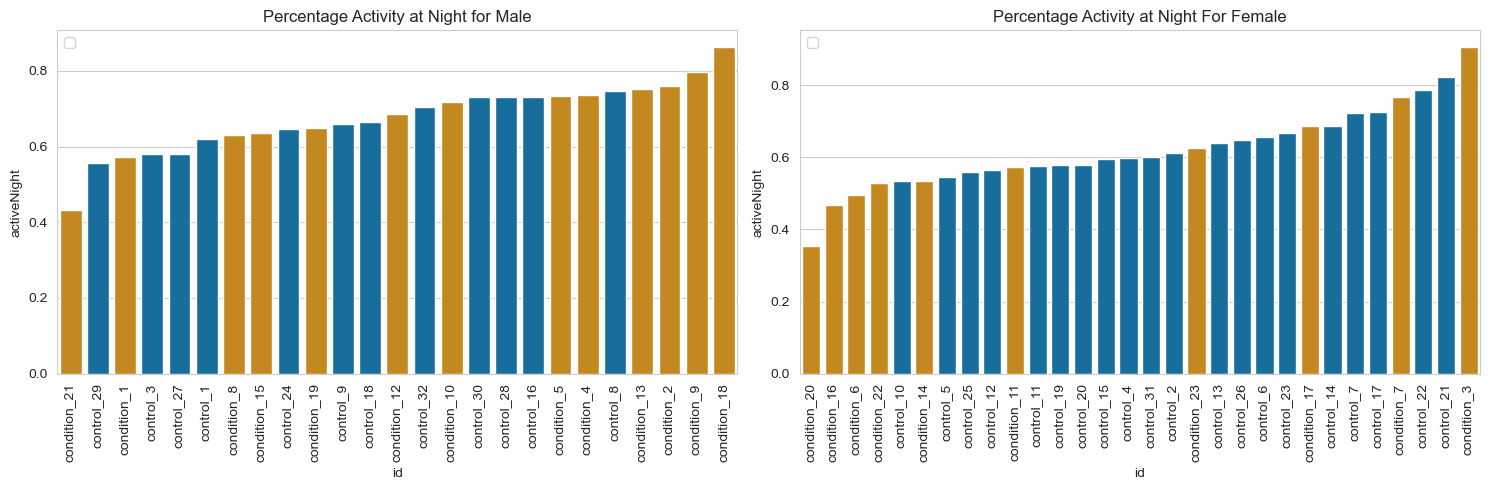

In [25]:
# Sort dataframes by 'activeNight' column
scaled_features_sortedM = ANM.sort_values(by='activeNight')
scaled_features_sortedN = ANF.sort_values(by='activeNight')

# Create a figure and two subplots, arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot data on the first subplot
sns.barplot(data=scaled_features_sortedM, x='id', y='activeNight', hue='label', dodge=False, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Percentage Activity at Night for Male")
axs[0].legend([])

# Plot data on the second subplot
sns.barplot(data=scaled_features_sortedN, x='id', y='activeNight', hue='label', dodge=False, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Percentage Activity at Night For Female")
axs[1].legend([])

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plots
plt.show()

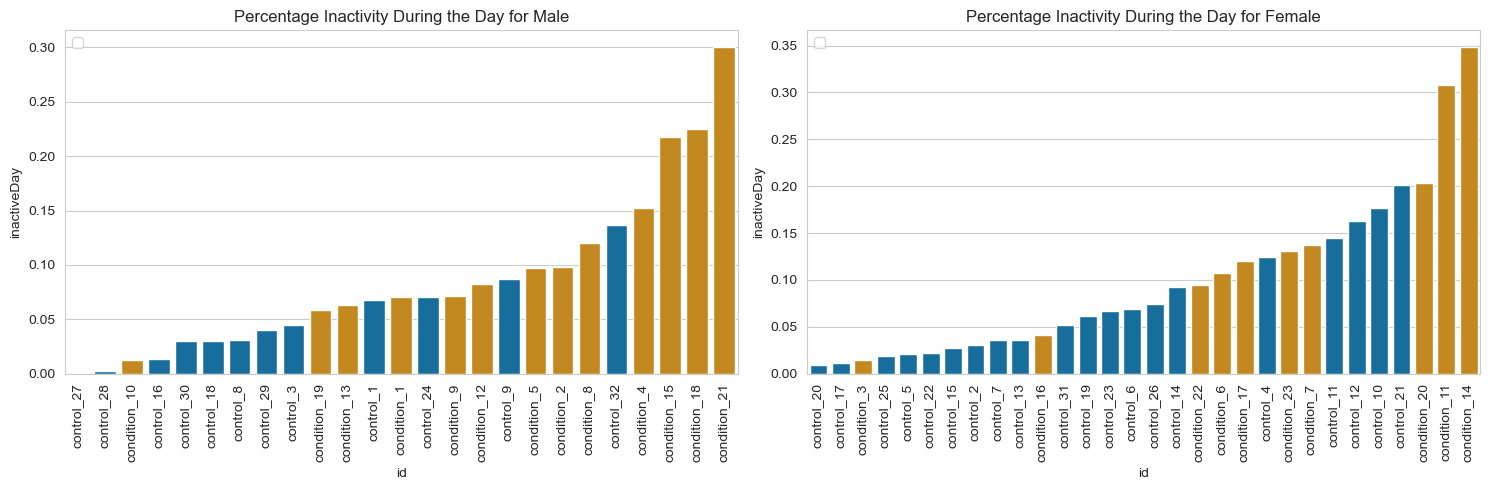

In [26]:
# Sort dataframes by 'activeNight' column
scaled_features_sortedM = ANM.sort_values(by='inactiveDay')
scaled_features_sortedN = ANF.sort_values(by='inactiveDay')

# Create a figure and two subplots, arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot data on the first subplot
sns.barplot(data=scaled_features_sortedM, x='id', y='inactiveDay', hue='label', dodge=False, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Percentage Inactivity During the Day for Male")
axs[0].legend([])

# Plot data on the second subplot
sns.barplot(data=scaled_features_sortedN, x='id', y='inactiveDay', hue='label', dodge=False, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Percentage Inactivity During the Day for Female")
axs[1].legend([])

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plots
plt.show()

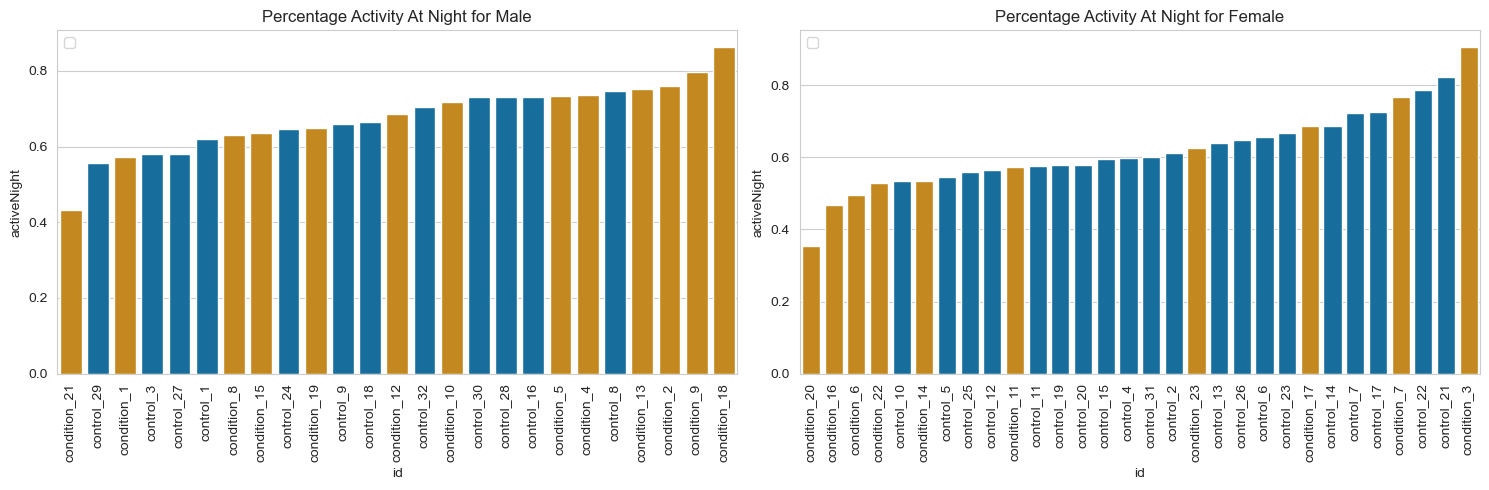

In [27]:
# Sort dataframes by 'activeNight' column
scaled_features_sortedM = ANM.sort_values(by='activeNight')
scaled_features_sortedN = ANF.sort_values(by='activeNight')

# Create a figure and two subplots, arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot data on the first subplot
sns.barplot(data=scaled_features_sortedM, x='id', y='activeNight', hue='label', dodge=False, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Percentage Activity At Night for Male")
axs[0].legend([])

# Plot data on the second subplot
sns.barplot(data=scaled_features_sortedN, x='id', y='activeNight', hue='label', dodge=False, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Percentage Activity At Night for Female")
axs[1].legend([])

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plots
plt.show()

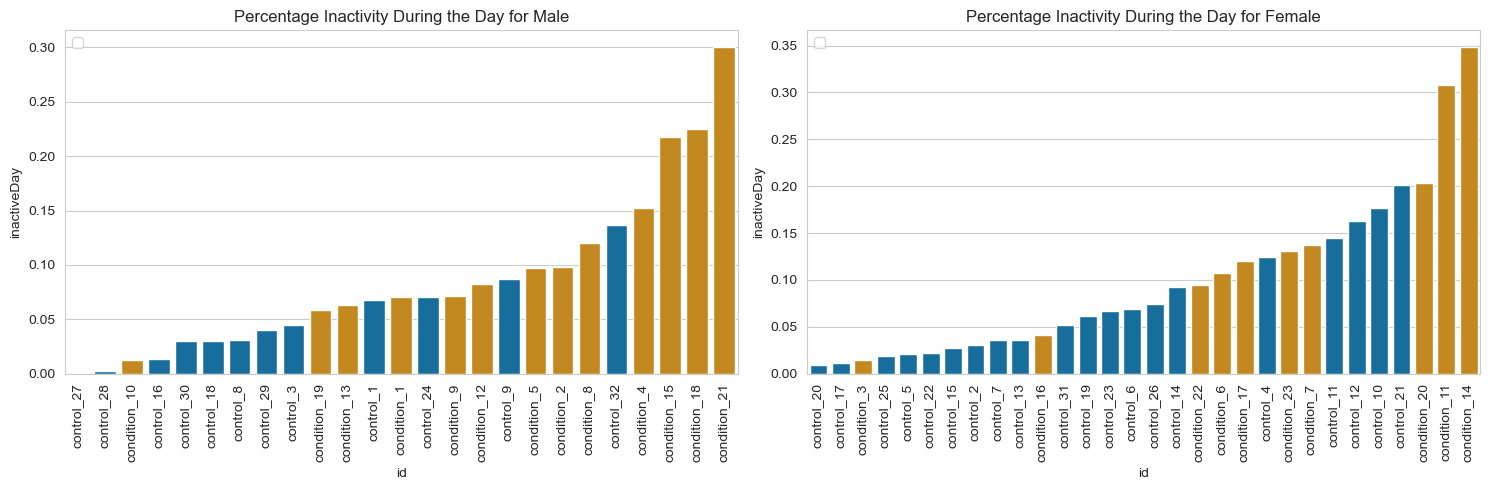

In [28]:
# Sort dataframes by 'activeNight' column
scaled_features_sortedM = ANM.sort_values(by='inactiveDay')
scaled_features_sortedN = ANF.sort_values(by='inactiveDay')

# Create a figure and two subplots, arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot data on the first subplot
sns.barplot(data=scaled_features_sortedM, x='id', y='inactiveDay', hue='label', dodge=False, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Percentage Inactivity During the Day for Male")
axs[0].legend([])

# Plot data on the second subplot
sns.barplot(data=scaled_features_sortedN, x='id', y='inactiveDay', hue='label', dodge=False, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Percentage Inactivity During the Day for Female")
axs[1].legend([])

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plots
plt.show()

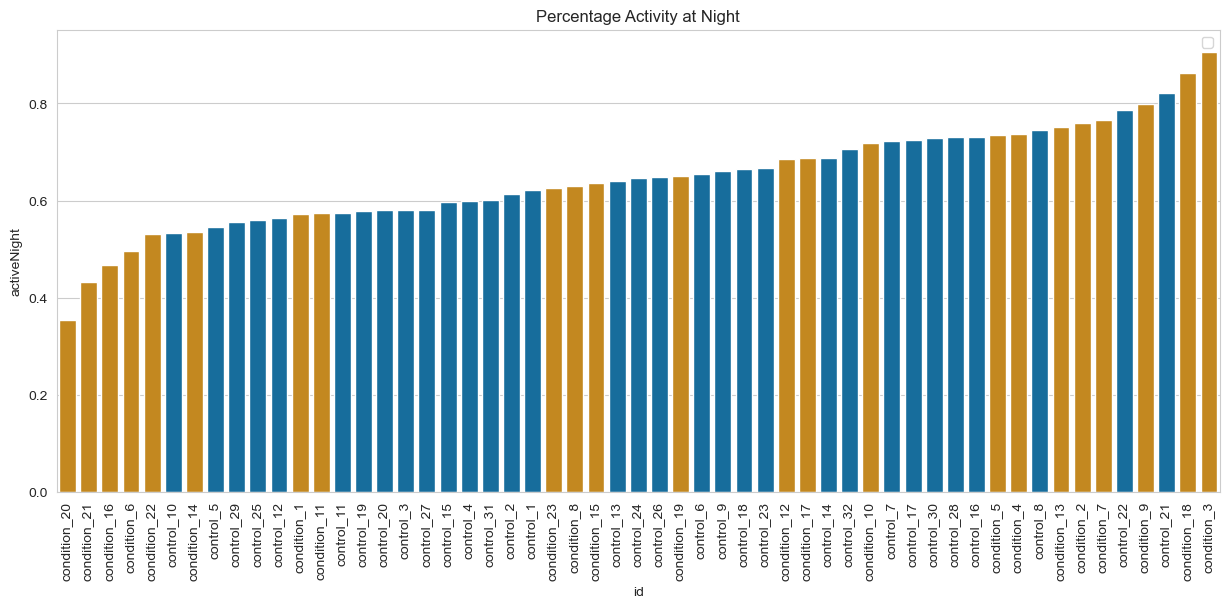

In [29]:
# Sort the DataFrame by the 'activeNight' column in descending order
scaled_features_sorted = AN.sort_values(by='activeNight')

# Set the figure size
plt.figure(figsize=(15, 6))

# Use barplot to create the stacked bar plot
sns.barplot(data=scaled_features_sorted, x='id', y='activeNight', hue='label', dodge=False)
plt.xticks(rotation=90)
plt.title("Percentage Activity at Night")
plt.legend([])
plt.show()

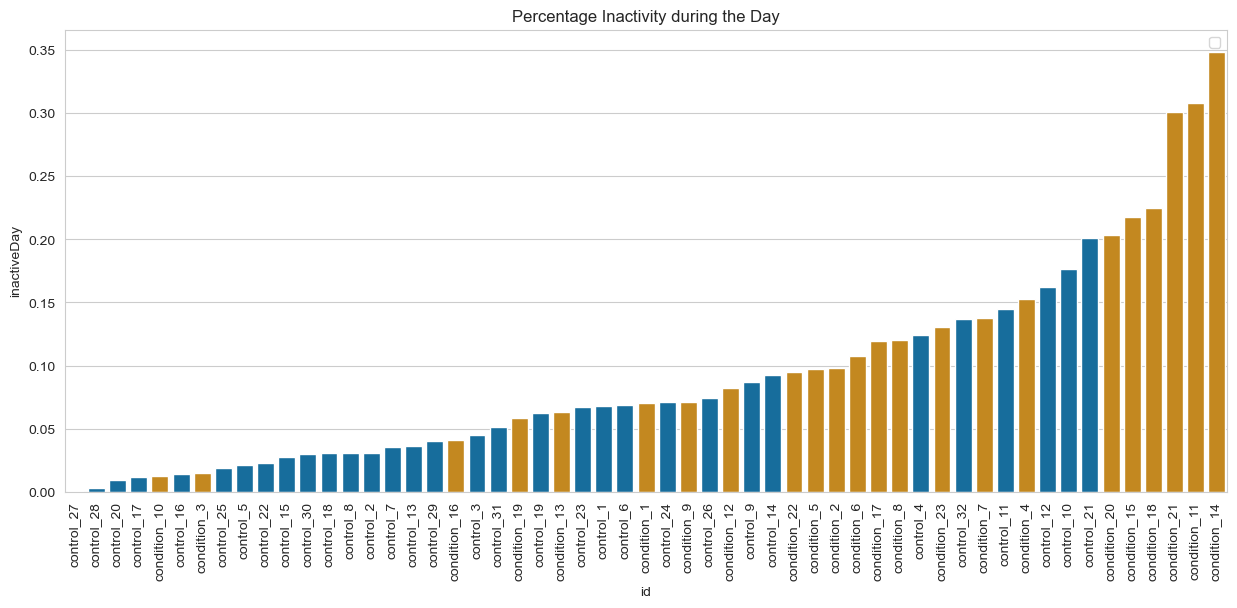

In [30]:
# Sort the DataFrame by the 'inactiveDay' column in descending order
scaled_features_sorted = AN.sort_values(by='inactiveDay')

# Set the figure size
plt.figure(figsize=(15, 6))

# Use barplot to create the stacked bar plot
sns.barplot(data=scaled_features_sorted, x='id', y='inactiveDay', hue='label', dodge=False)
plt.xticks(rotation=90)
plt.title("Percentage Inactivity during the Day")
plt.legend([])
plt.show()

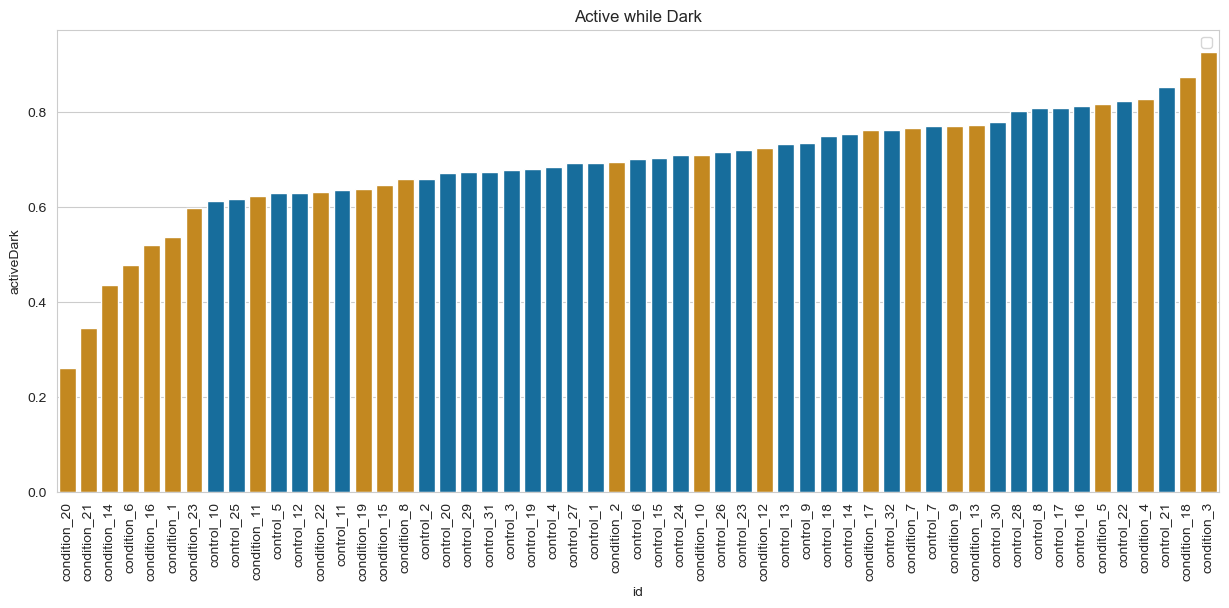

In [31]:
# Sort the DataFrame by the 'activeNight' column in descending order
scaled_features_sorted = AN.sort_values(by='activeDark')

# Set the figure size
plt.figure(figsize=(15, 6))

# Use barplot to create the stacked bar plot
sns.barplot(data=scaled_features_sorted, x='id', y='activeDark', hue='label', dodge=False)
plt.xticks(rotation=90)
plt.legend([])
plt.title("Active while Dark")
plt.show()

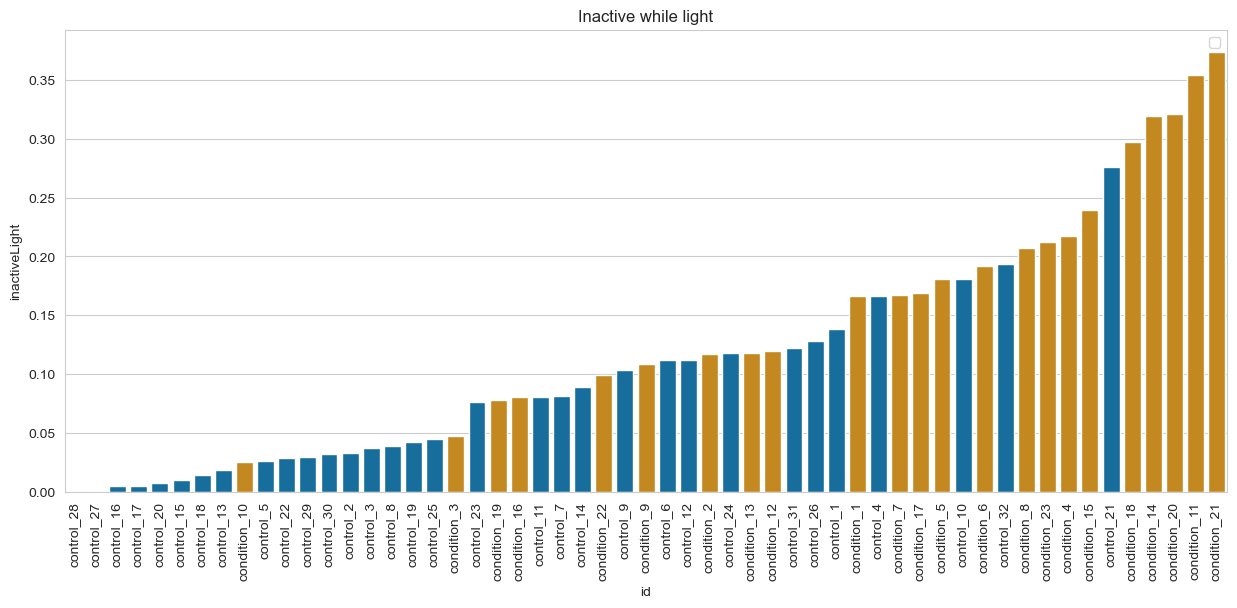

In [32]:
# Sort the DataFrame by the 'activeNight' column in descending order
scaled_features_sorted = AN.sort_values(by='inactiveLight')

# Set the figure size
plt.figure(figsize=(15, 6))

# Use barplot to create the stacked bar plot
sns.barplot(data=scaled_features_sorted, x='id', y='inactiveLight', hue='label', dodge=False)
plt.xticks(rotation=90)
plt.legend([])
plt.title("Inactive while light")
plt.show()

In [33]:
Depression_severity = []
size = len(scores['madrs1'])

for n in range (0,size):
    
    if pd.isna(scores['madrs1'][n]):
        Depression_severity.append(np.nan)
        
    elif int(scores['madrs1'][n]) > 35 and int(scores['madrs2'][n]) > 35:
        Depression_severity.append(3)
    
    elif 18 <= int(scores['madrs1'][n]) <= 34 and 18 <= int(scores['madrs2'][n]) <= 34:
        Depression_severity.append(2)
    
    elif 9 <= int(scores['madrs1'][n]) <= 17 and 9 <= int(scores['madrs2'][n]) <= 17:
        Depression_severity.append(1)

    elif 0 <= int(scores['madrs1'][n]) <= 8 and 0 <= int(scores['madrs2'][n]) <= 8:
        Depression_severity.append(0)
    
    elif int(scores['madrs1'][n]) > int(scores['madrs2'][n]):
        Depression_severity.append('Imp')
        
    elif int(scores['madrs1'][n]) < int(scores['madrs2'][n]):
        Depression_severity.append('Red')
        
scores['depression_severity'] = Depression_severity

In [34]:
scores.head()

,id,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2,depression_severity
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0,2
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0,Imp
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0,2
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0,Imp
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0,2


In [35]:
merged_df['Days']=pd.to_datetime(merged_df['timestamp']).dt.day

In [36]:
# Min-max scaling

def min_max_scale(dataframe):
    norm = np.tanh(values)
    return (norm) 


In [37]:
merged_df.head()

,timestamp,date,activity,id,label,gender,day_night,active_inactive,light_dark,Days
0,2003-03-19 00:00:00,2003-03-19,0,control_1,0,2,1,0,1,19
1,2003-03-19 00:01:00,2003-03-19,0,control_1,0,2,1,0,1,19
2,2003-03-19 00:02:00,2003-03-19,0,control_1,0,2,1,0,1,19
3,2003-03-19 00:03:00,2003-03-19,0,control_1,0,2,1,1,1,19
4,2003-03-19 00:04:00,2003-03-19,175,control_1,0,2,1,1,1,19


In [38]:
def Percentzero (values):
    zeros = (values == 0).sum().sum()
    total_values = values.size
    return zeros / total_values * 100


# create a function to produce a table of features listed above

def extract_features(dataframe):
    
    # Group by 'id' and 'label' columns
    grouped = dataframe.groupby(['id', 'label','gender'])['activity']

    # Calculate statistics for 'standardised_activity' within each group
    features1_df = pd.DataFrame({
        'mean' : grouped.mean(),
        'std' : grouped.std(),
        'max' : grouped.max(),
        '%zero': grouped.apply(Percentzero),
        'kurtosis': grouped.apply(lambda x: sp.kurtosis(x, fisher=False))
    })

    return features1_df
    
features = extract_features(merged_df).reset_index()

In [39]:
Female_features = features[features['gender'] == 1]
Male_features = features[features['gender'] == 2]

In [40]:
features

,id,label,gender,mean,std,max,%zero,kurtosis
0,condition_1,1,2,157.517614,276.598459,3526,41.666667,15.909135
1,condition_10,1,2,334.584259,439.438546,4935,32.391975,8.183294
2,condition_11,1,1,133.718651,280.246726,3002,54.508929,13.761354
3,condition_12,1,2,171.433912,279.754460,3622,36.875000,14.424340
4,condition_13,1,2,260.378175,363.494858,4859,33.144841,9.618971
5,condition_14,1,1,73.919345,183.038816,2929,63.239087,30.400754
6,condition_15,1,2,113.947329,233.404689,6825,48.627137,60.096761
7,condition_16,1,1,244.083594,388.074868,6964,40.190972,20.753153
8,condition_17,1,1,87.237019,156.748786,1882,38.723291,17.661631
9,condition_18,1,2,72.569338,135.011546,1355,45.283120,16.818954


In [41]:
# Min-max scaling

col_list = ['mean','std','%zero','kurtosis','max']

def min_max_scale(dataframe,col_list):
    
    df = dataframe.copy()
    
    for col in col_list:
        Xmin = df[col].min()
        Xmax = df[col].max()    
        
        if Xmax-Xmin > 0:
            df[col] = (df[col]-Xmin)/(Xmax-Xmin)
        
    return (df)

scaled_features = min_max_scale(features,col_list)

In [42]:
scaled_features

,id,label,gender,mean,std,max,%zero,kurtosis
0,condition_1,1,2,0.251412,0.279860,0.326712,0.619589,0.188757
1,condition_10,1,2,0.746866,0.601729,0.538751,0.481673,0.046918
2,condition_11,1,1,0.184819,0.287071,0.247856,0.810555,0.149326
3,condition_12,1,2,0.290351,0.286098,0.341159,0.548336,0.161498
4,condition_13,1,2,0.539228,0.451619,0.527314,0.492868,0.073276
5,condition_14,1,1,0.017494,0.094931,0.236870,0.940373,0.454810
6,condition_15,1,2,0.129497,0.194484,0.823175,0.723092,1.000000
7,condition_16,1,1,0.493634,0.500204,0.844093,0.597645,0.277689
8,condition_17,1,1,0.054758,0.042966,0.079308,0.575820,0.220931
9,condition_18,1,2,0.013716,0.000000,0.000000,0.673366,0.205461


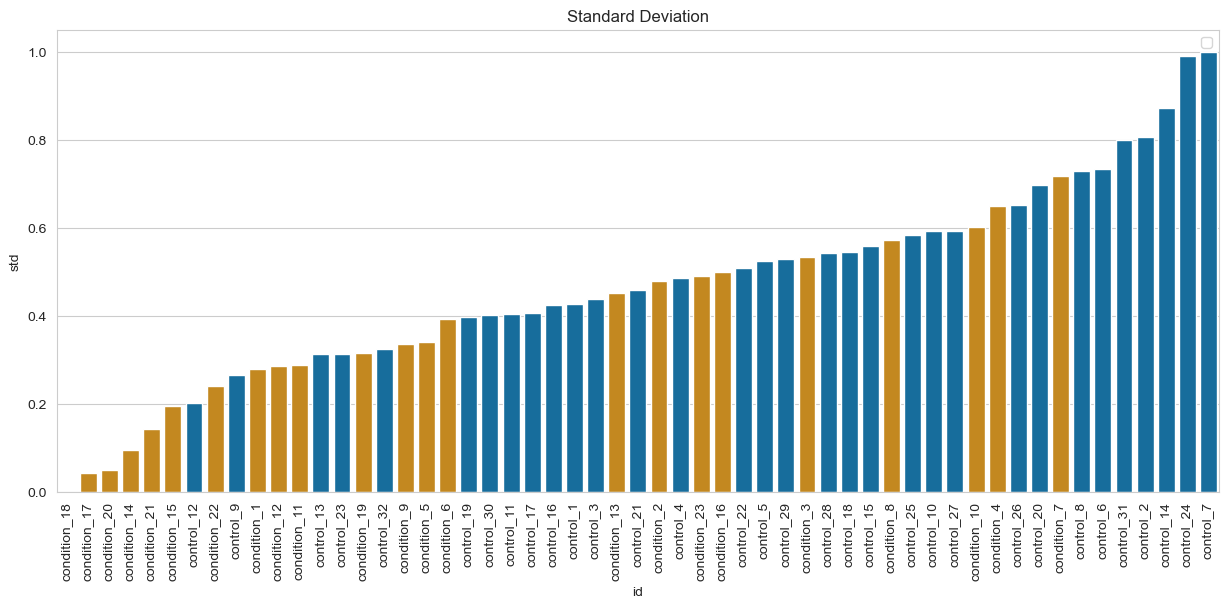

In [43]:
# Sort the DataFrame by the 'std' column in descending order
scaled_features_sorted = scaled_features.sort_values(by='std')

# Set the figure size
plt.figure(figsize=(15, 6))

# Use barplot to create the stacked bar plot
sns.barplot(data=scaled_features_sorted, x='id', y='std', hue='label', dodge=False)
plt.xticks(rotation=90)
plt.title("Standard Deviation")
plt.legend([])
plt.show()

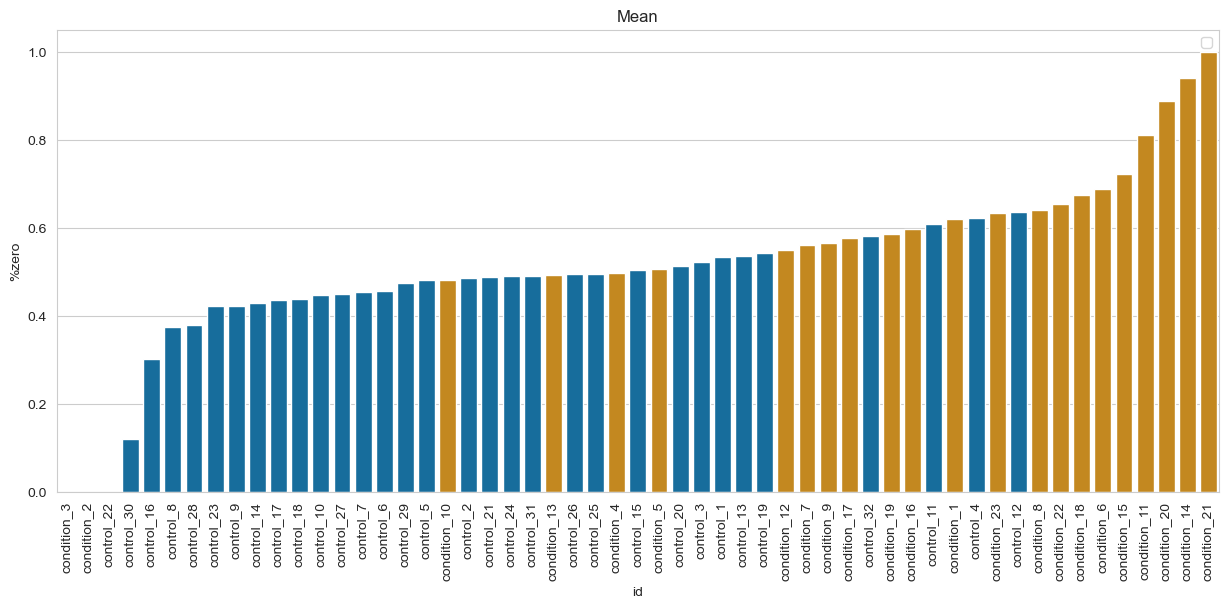

In [44]:
# Sort the DataFrame by the 'mean' column in descending order
scaled_features_sorted = scaled_features.sort_values(by='%zero')

# Set the figure size
plt.figure(figsize=(15, 6))

# Use barplot to create the stacked bar plot
sns.barplot(data=scaled_features_sorted, x='id', y='%zero', hue='label', dodge=False)
plt.xticks(rotation=90)
plt.title("Mean")
plt.legend([])
plt.show()

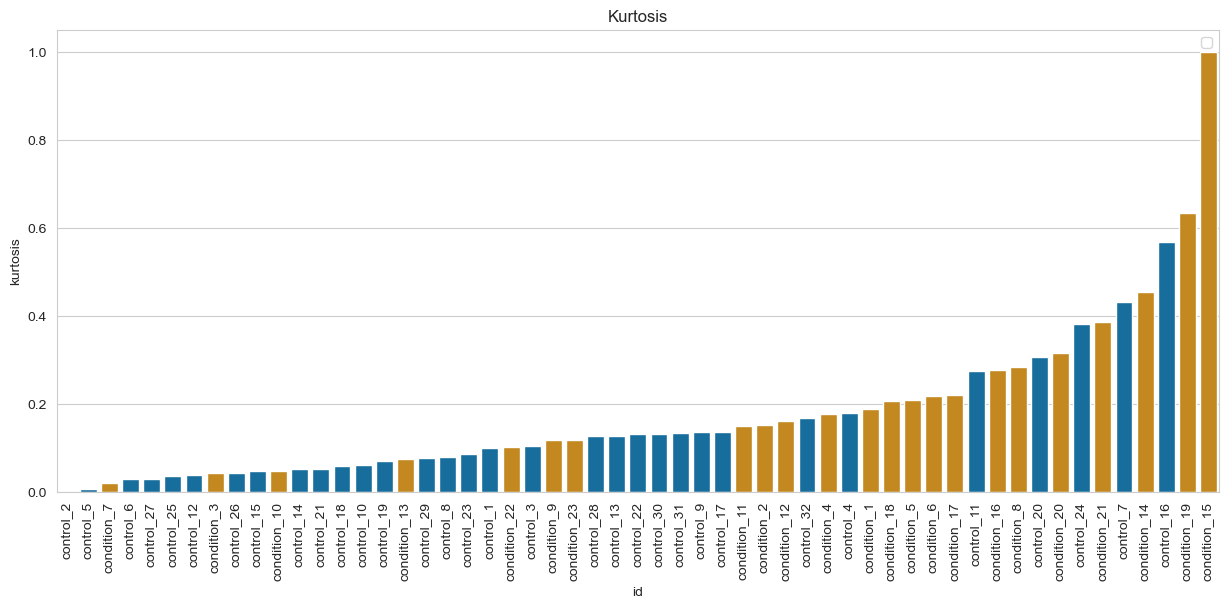

In [45]:
# Sort the DataFrame by the 'kurtosis' column in descending order
scaled_features_sorted = scaled_features.sort_values(by='kurtosis')

# Set the figure size
plt.figure(figsize=(15, 6))

# Use barplot to create the stacked bar plot
sns.barplot(data=scaled_features_sorted, x='id', y='kurtosis', hue='label', dodge=False)
plt.xticks(rotation=90)
plt.title("Kurtosis")
plt.legend([])
plt.show()

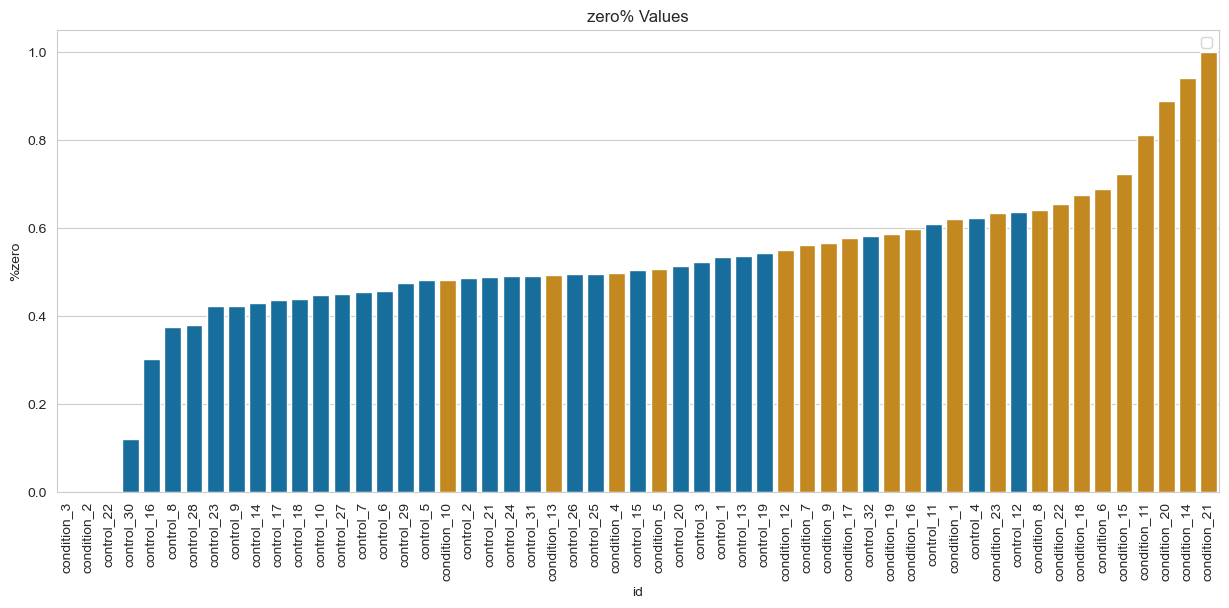

In [46]:
# Sort the DataFrame by the 'max' column in descending order
scaled_features_sorted = scaled_features.sort_values(by='%zero')

# Set the figure size
plt.figure(figsize=(15, 6))

# Use barplot to create the stacked bar plot
sns.barplot(data=scaled_features_sorted, x='id', y='%zero', hue='label', dodge=False)
plt.xticks(rotation=90)
plt.legend()
plt.title("zero% Values")
plt.legend([])
plt.show()

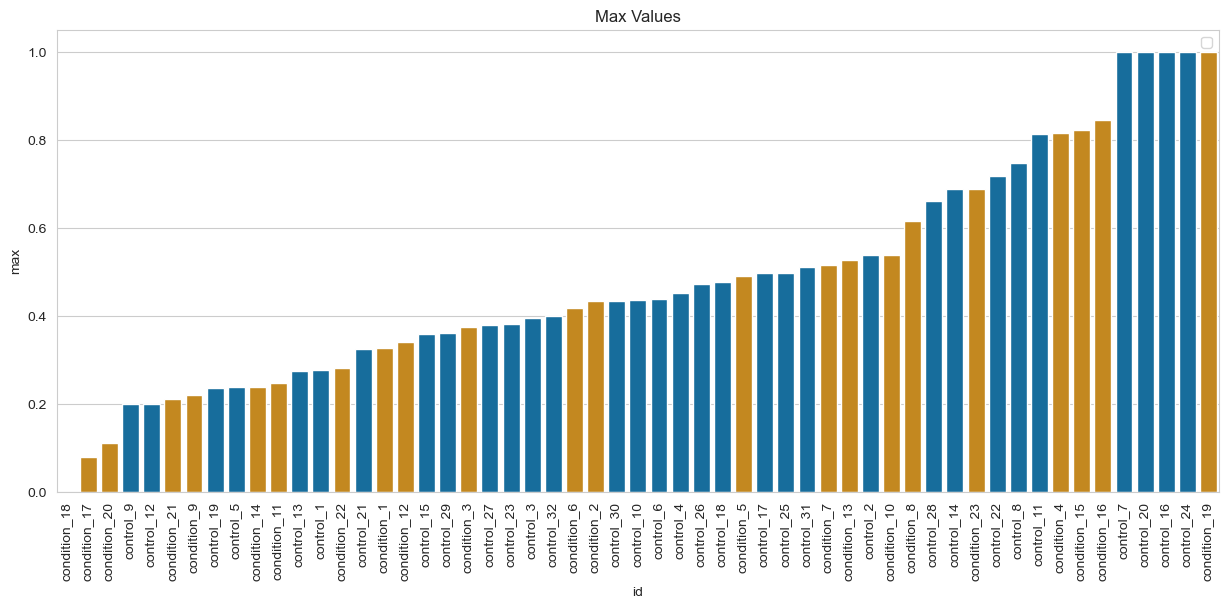

In [47]:
# Sort the DataFrame by the 'max' column in descending order
scaled_features_sorted = scaled_features.sort_values(by='max')

# Set the figure size
plt.figure(figsize=(15, 6))

# Use barplot to create the stacked bar plot
sns.barplot(data=scaled_features_sorted, x='id', y='max', hue='label', dodge=False)
plt.xticks(rotation=90)
plt.legend()
plt.title("Max Values")
plt.legend([])
plt.show()

In [48]:
scores

,id,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2,depression_severity
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0,2
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0,Imp
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0,2
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0,Imp
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0,2
5,condition_6,7,1,35-39,2.0,2.0,2.0,6-10,1.0,2.0,18.0,15.0,Imp
6,condition_7,11,1,20-24,1.0,NaN,2.0,11-15,2.0,1.0,24.0,25.0,2
7,condition_8,5,2,25-29,2.0,NaN,2.0,11-15,1.0,2.0,20.0,16.0,Imp
8,condition_9,13,2,45-49,1.0,NaN,2.0,6-10,1.0,2.0,26.0,26.0,2
9,condition_10,9,2,45-49,2.0,2.0,2.0,6-10,1.0,2.0,28.0,21.0,2


In [50]:
AN

,id,activeNight,inactiveDay,activeDark,inactiveLight,label
0,control_1,0.621181,0.068229,0.693510,0.138694,0
1,control_22,0.786859,0.022543,0.824022,0.028351,0
2,control_23,0.667521,0.067308,0.720039,0.076641,0
3,control_24,0.645833,0.070726,0.709045,0.117460,0
4,control_25,0.559829,0.018803,0.617816,0.044741,0
5,control_26,0.647756,0.074359,0.716265,0.128084,0
6,control_31,0.601935,0.051496,0.674926,0.121759,0
7,control_32,0.705589,0.136905,0.761919,0.193154,0
8,control_6,0.655376,0.068803,0.700553,0.111603,0
9,control_7,0.722581,0.035470,0.770630,0.081569,0


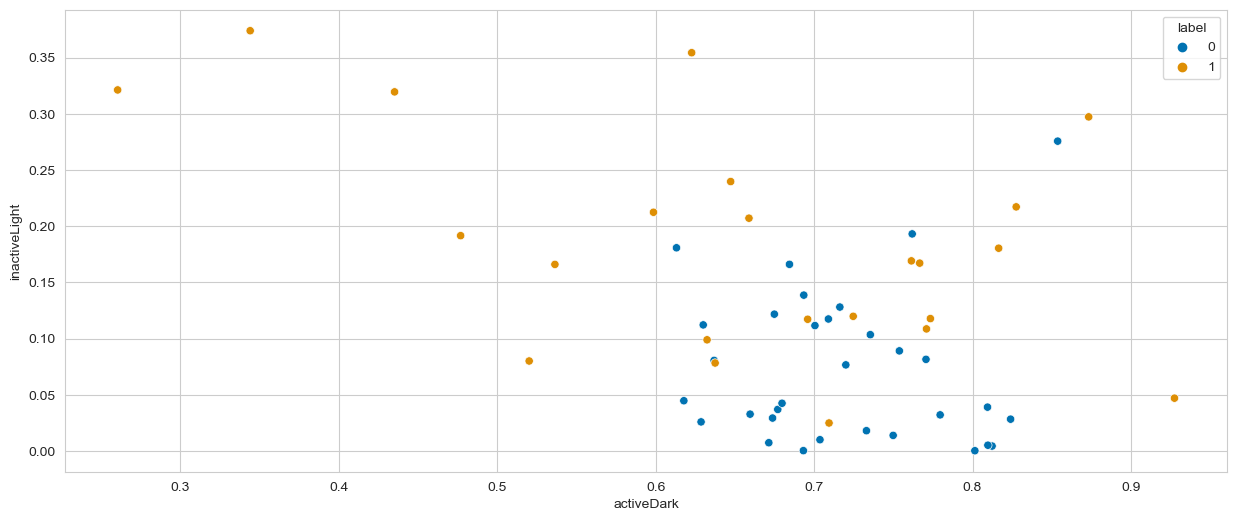

In [54]:

# Set the figure size
plt.figure(figsize=(15, 6))

# Use barplot to create the stacked bar plot
sns.scatterplot(data=AN, x='activeDark', y='inactiveLight', hue='label')
plt.show()

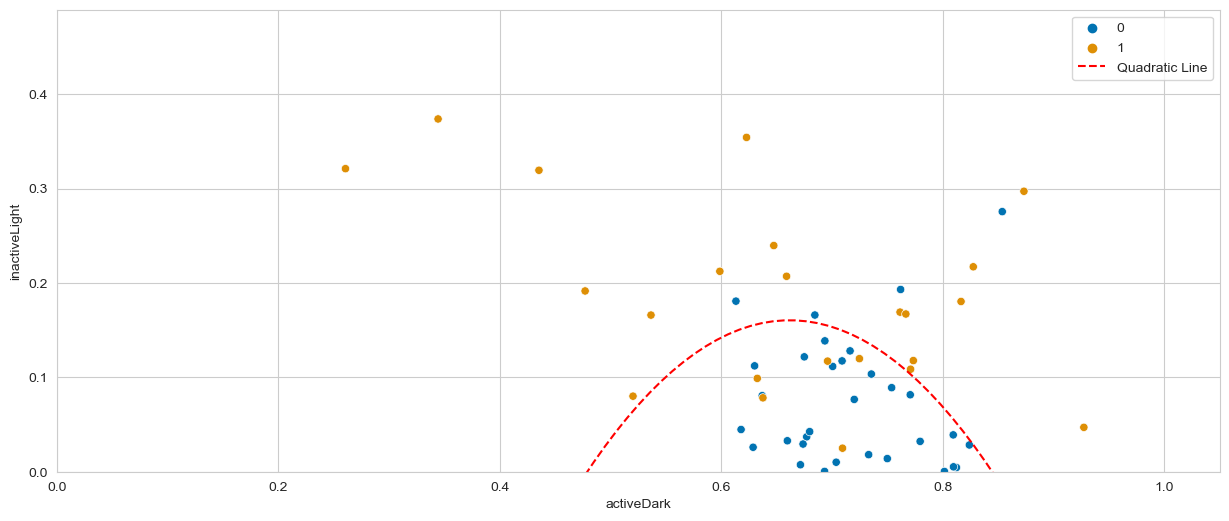

In [95]:
# Create a quadratic function
def quadratic_func(x, a, b, c, d):
    return a * (x - b) * (x - c) + d

# Generate x values
x_values = np.linspace(0, 1, 100)

# Define roots and coefficient
root1 = 0.42
root2 = 0.9035
coefficient = -4.8  # Negative coefficient of x^2
d = -0.12

# Compute the y values for the quadratic function
y_values = quadratic_func(x_values, coefficient, root1, root2, d)

# Set the figure size
plt.figure(figsize=(15, 6))

# Use scatterplot to create the plot
sns.scatterplot(data=AN, x='activeDark', y='inactiveLight', hue='label')

# Plot the quadratic line
plt.plot(x_values, y_values, color='red', linestyle='--', label='Quadratic Line')

# Set x-axis and y-axis limits to start from zero
plt.xlim(0, None)
plt.ylim(0, None)

# Show legend
plt.legend()
# Show plot
plt.show()

c:\Users\44778\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


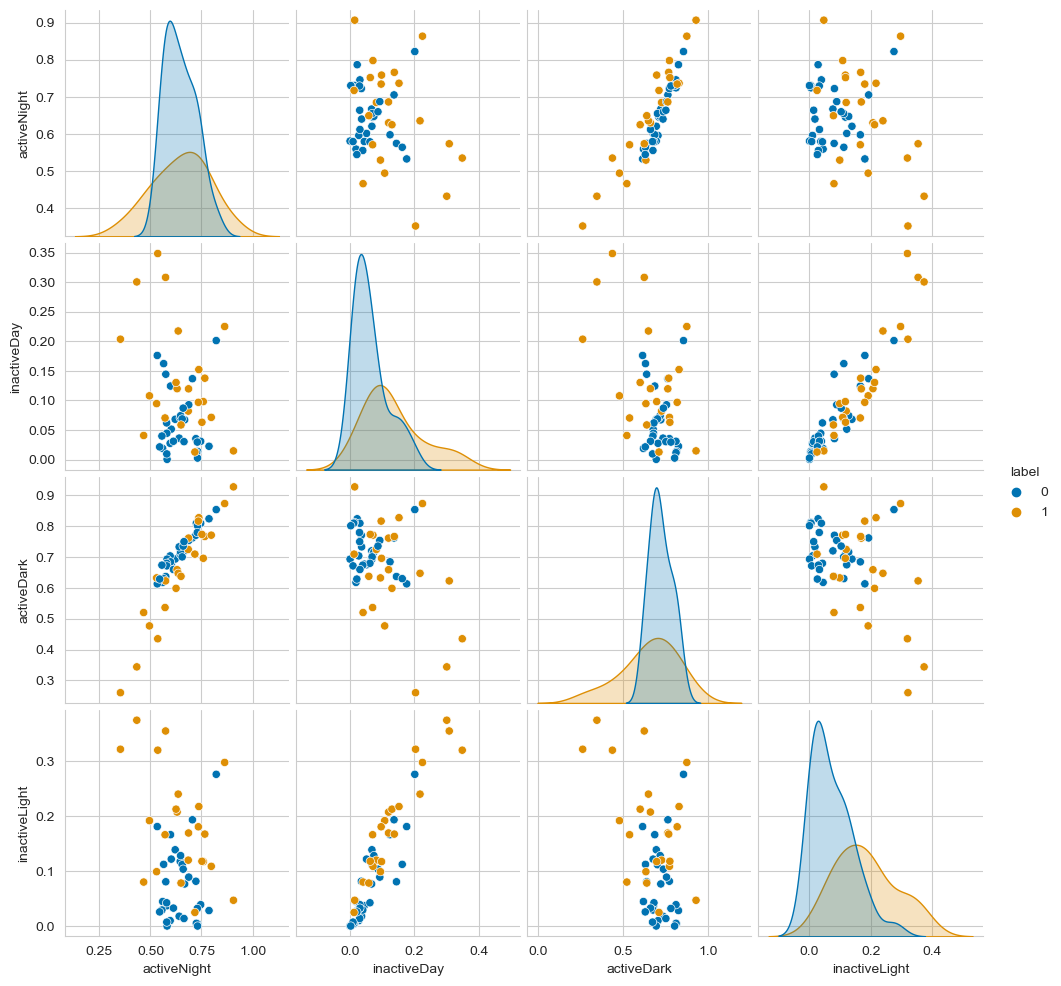

In [97]:
sns.pairplot(AN,hue='label')